<a href="https://colab.research.google.com/github/melimes/Financial-Models-Numerical-Methods/blob/master/EvolutionOperatorSpin1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from numpy import  *
import matplotlib.pyplot as plt
from math import pi
from scipy.signal import hilbert, butter, filtfilt, periodogram
from scipy.fft import fft, fftfreq,fftshift , ifft
import time
from scipy.stats import sem
from scipy.linalg import expm
import pandas as pd

from numba import jit

class spin_matrix:
  def __init__(self, S):
    self.spin = S
    self.size = int(rint(S/(1/2))+1)
    self.x = asmatrix(zeros((self.size,self.size), dtype = complex))
    self.y = asmatrix(zeros((self.size,self.size), dtype = complex))
    self.z = asmatrix(zeros((self.size,self.size), dtype = complex))
    self.p = asmatrix(zeros((self.size,self.size), dtype = complex))
    self.m = asmatrix(zeros((self.size,self.size), dtype = complex))
    self.s2 = asmatrix(zeros((self.size,self.size), dtype = complex))
    self.order = arange(S,-S-1,-1)

    for i in range(self.size):
        for k in range(self.size):
           self.x[(k,i)] =  ((int(equal(i,k+1)) + int(equal(i+1,k)))/2)*sqrt(S*(S+1)-self.order[i]*self.order[k])
           self.y[(k,i)] = -1j* ((int(equal(i,k+1)) - int(equal(i+1,k)))/2)*sqrt(S*(S+1) -self.order[i]*self.order[k]);
           self.z[(k,i)] = (int(equal(i,k)))*self.order[i];
           self.p[(k,i)] = (int(equal(i,k+1)))*sqrt(S*(S+1) - self.order[k]*self.order[i]);
           self.m[(k,i)] = (int(equal(i+1,k)))*sqrt(S*(S+1) - self.order[k]*self.order[i]);
           self.s2[(k,i)] = (int(equal(i,k)))*S*(S+1);

def powerSpectralDensity(x, Fs):
    freqs, psd = periodogram(x, Fs, detrend='linear', scaling='density', window='blackmanharris')
    psd = sqrt(psd)
    freqs = freqs[1:] # Skip zero Hz element
    psd = psd[1:]
    return freqs, psd

One place to start, is to look at Pauli rotations for a spin-1/2 operator. J.J. Sakurai's Modern Quantum Mechanics Chapter 3 is the best treatment of angular momentum I've seen. The rest of the book is not as good, but it is a text that I believe he passed away during writing, so it's hard to tell if the clarity of thought on Chapter 3 was his or the people who finished writing it, but left it solely in his name.

From 3.2.42 of Sakuri, we have the rotation operator $D(\hat{n}, \phi)$, where $\hat{n}$ is a unit vector representing the axis we want to rotate about, and $\phi$ is an angle for which you rotate about the direction $\hat{n}$.


$D(\hat{n}, \phi) = \exp(-iS\cdot\hat{n}\phi /\hbar)= \exp(-i\sigma\cdot\hat{n}\phi /2)$    

You can show this is equal to the matrix

$\exp(-i\sigma\cdot\hat{n}\phi /2) =
\begin{pmatrix}
\cos(\phi/2)-in_z\sin(\phi/2) & (-in_x-n_y)\sin(\phi/2)\\
(-in_x-n_y)\sin(\phi/2) & \cos(\phi/2)+in_z\sin(\phi/2)
\end{pmatrix}$

Note that the usual Pauli matrices are defined using 1's, i.e.

$\sigma_1 = \sigma_x = \begin{pmatrix}
0 &1\\
1 & 0
\end{pmatrix} $, $\sigma_2 = \sigma_y = \begin{pmatrix}
0 &-i\\
i & 0
\end{pmatrix} $$\sigma_3 = \sigma_z = \begin{pmatrix}
1 &0\\
0 & -1
\end{pmatrix} $

that have the product relation $\sigma_i \sigma_j = \delta_{ij} + i \epsilon_{ijk}\sigma_k$.

(For the below I drop $\hbar$ factor in the spin operator def...)

$i\hbar \frac{d}{dt}|\Psi> = \hat{H}|\Psi>$ <- Schrodinger Eq.

Ignore all spatial variables for our problems :).
We are only interested in angular momentum

Our Hamiltonians will look like $\gamma B\cdot S$, where $\gamma$ is the gyromagnetic ratio / coupling strength, $B$ is a magnetic field vector, $S$ is a spin operator vector

$|\Psi(t)> = e^{-i\hat{H}t/\hbar}|\Psi(0)>$

Look at $B = B_z$, then $\hat{H} = \gamma B_zS_z$, where $S_z = \hbar\sigma_z/2 = \frac{\hbar}{2}\begin{pmatrix}
1 &0\\
0 & -1
\end{pmatrix}$.

Then the time-evolution operator is

$U(t)=e^{-i\hat{H}t/\hbar} = e^{-i\frac{\gamma B}{2}\begin{pmatrix}
1 &0\\
0 & -1
\end{pmatrix}t}=e^{-i\gamma B \begin{pmatrix}
\frac{1}{2} &0\\
0 & -\frac{1}{2}
\end{pmatrix}t}
= \begin{pmatrix}
\cos(\gamma B_z t/2)-i\sin(\gamma B_z t/2) & 0\\
0 & \cos(\gamma B_z t/2)+i\sin(\gamma B_z t/2)
\end{pmatrix}$

You can pick a state that is on a plane transverse to $B_z$, for example spin along x

$|\Psi(0)>=\frac{1}{\sqrt{2}}|\uparrow>+\frac{1}{\sqrt{2}}|↓> =
\begin{pmatrix}
\frac{1}{\sqrt{2}} \\
\frac{1}{\sqrt{2}}
\end{pmatrix} $


$<\Psi(0)| = \begin{pmatrix}
\frac{1}{\sqrt{2}}&\frac{1}{\sqrt{2}}
\end{pmatrix}$  <- Complex conjugate transpose for 'bra'

Expectation values look like

$<\Psi(0)| S_x|\Psi(0)> = \hbar/2$

$<\Psi(0)| S_y|\Psi(0)> = 0$

$<\Psi(0)| S_z|\Psi(0)> = 0$

In [ ]:
state = matrix([[1/sqrt(2)],
       [1/sqrt(2)]]) #Initial state along x-axis

print(state.T)
S = spin_matrix(1/2) #creates Pauli spin matrices
print(matmul(state.T,matmul(S.x*2,state)))
print(state.H@S.x*2@state)

[[0.70710678 0.70710678]]
[[1.+0.j]]
[[1.+0.j]]


timestep is  1e-07 s, sample frequency is 10.0 MHz
[[-0.58778525-0.80901699j  0.        +0.j        ]
 [ 0.        +0.j         -0.58778525+0.80901699j]]


<ipython-input-39-c1519c64e584>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xProj[i] =(currentState.H@S.x*2*currentState).real #.H is complex conjugate plus transpose, @ is matrix multiplication - expectation val to Sx


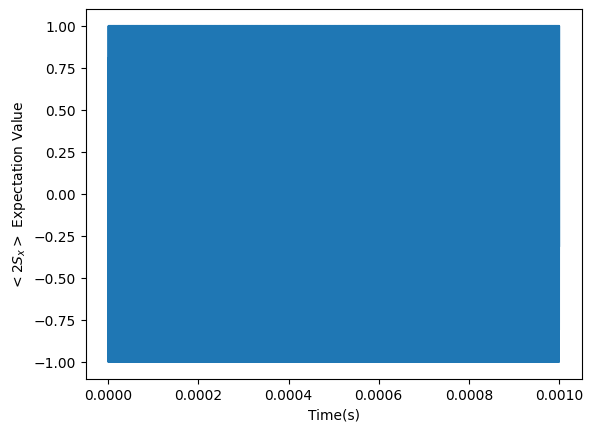

Text(0.5, 0, 'Freq. (Hz)')

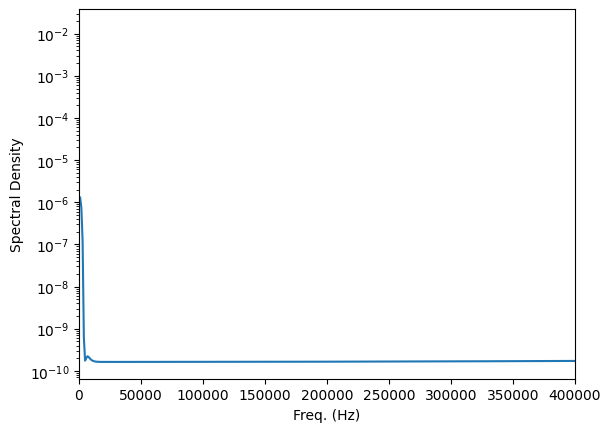

In [ ]:
numtimesteps = 10001
time = linspace(0,1e-3, numtimesteps)
tstep = time[1]-time[0]
fs = 1/tstep #sample frequency
print(f"timestep is  {tstep} s, sample frequency is {fs*1e-6} MHz")
gRb = 7e9 #Hz/T 87Rb gyromagnetic ratio
B = 1e-3 #T Bias field

U = asmatrix(expm(-1j*2*pi*gRb*B*tstep*S.z))
print(U)
xProj = zeros(numtimesteps)
Uiter = U
currentState = state

for i in range(numtimesteps):
  currentState = Uiter@currentState
  xProj[i] =(currentState.H@S.x*2*currentState).real #.H is complex conjugate plus transpose, @ is matrix multiplication - expectation val to Sx

plt.plot(time,xProj)
plt.ylabel('$<2S_x>$ Expectation Value')
plt.xlabel('Time(s)')
plt.show()

freqs, FFTsig =  powerSpectralDensity(xProj,fs)
plt.semilogy(freqs, FFTsig)
plt.xlim(0,4e5)
plt.ylabel('Spectral Density')
plt.xlabel('Freq. (Hz)')

# Spin 3/2,1/2

Defining new spin matrices

Inital State, hamiltonian, and projections with new dim

In [ ]:
#State vectors for spin-1/2 and spin-3/2
state_1_2 = matrix([[1/sqrt(2)], [1/sqrt(2)]])
#state_3_2 = matrix([[1/sqrt(2)], [0], [0], [1/sqrt(2)]]) #change dim to 4x1 for spin-3/2
#state_3_2 = matrix([[1/2], [1/2], [1/2], [1/2]])
zpol = matrix([[1],[0],[0],[0]])

I_3_2 = spin_matrix(3/2)
state_3_2=expm(-1j*I_3_2.y*pi/2)@zpol #rotating to create x polarized state, described in z basis

print("1/2 State")
print(state_1_2.T)
S_1_2 = spin_matrix(1/2)
print(matmul(state_1_2.T,matmul(S_1_2.x*2,state_1_2)))
print(state_1_2.H@S_1_2.x*2@state_1_2)
print("\n3/2 State")
print(state_3_2.T)
print(matmul(state_3_2.T,matmul(I_3_2.x,state_3_2)))
print(state_3_2.H@I_3_2.x@state_3_2)

combined_state = kron(state_3_2, state_1_2) #tensor product of initial states
print("\n combined state")
print(combined_state)

print("x projections of full state")
print(combined_state.H@(kron(identity(I_3_2.size),S_1_2.x))@combined_state)

1/2 State
[[0.70710678 0.70710678]]
[[1.+0.j]]
[[1.+0.j]]

3/2 State
[[0.35355339+0.j 0.61237244+0.j 0.61237244+0.j 0.35355339+0.j]]
[[1.5+0.j]]
[[1.5+0.j]]

 combined state
[[0.25     +0.j]
 [0.25     +0.j]
 [0.4330127+0.j]
 [0.4330127+0.j]
 [0.4330127+0.j]
 [0.4330127+0.j]
 [0.25     +0.j]
 [0.25     +0.j]]
x projections of full state
[[0.5+0.j]]


$H_{total}=H_{3/2}+H_{1/2}+H_{int}​$

$=H_{3/2}+H_{1/2}+JS_{3/2}\cdot JS_{1/2}:​$

$H_{tot}=\gamma_n I\cdot B+\gamma_e S\cdot B+A_{hyp}I\cdot S$

$H_{tot}=\gamma_F F\cdot B$ (well-coupled basis F=I+S)

Notes:
1) An x polarized spin-3/2 in the z basis can be found by taking a z polarized spin3/2 I'm z basis and rotating 90 degrees about I.y

2), the gyromagnetic ratio of the electron and rb nucleus are different (see below)

3) the hyperfine interaction strength is like 6.8 GHz (not sure if I'm putting that in hamiltonian correctly

4) We can also iterate the problem in the coupled basis...

https://steck.us/alkalidata/


Combined Hamiltonian:


,0,1,2,3,4,5,6,7
0,-5.139492e+09+0.000000e+ 00j,0.000000e+00+0.000000e+ 00j,0.000000e+00+0.000000e+ 00j,0.000000e+00+0.000000e+ 00j,0.000000e+00+0.000000e+ 00j,0.000000e+00+0.000000e+ 00j,0.000000e+00+0.000000e+ 00j,0.000000e+00+0.000000e+ 00j
1,0.000000e+00+0.000000e+ 00j,5.139533e+09+0.000000e+ 00j,-5.918418e+09+0.000000e+ 00j,0.000000e+00+0.000000e+ 00j,0.000000e+00+0.000000e+ 00j,0.000000e+00+0.000000e+ 00j,0.000000e+00+0.000000e+ 00j,0.000000e+00+0.000000e+ 00j
2,0.000000e+00+0.000000e+ 00j,-5.918418e+09+0.000000e+ 00j,-1.722505e+09+0.000000e+ 00j,0.000000e+00+0.000000e+ 00j,0.000000e+00+0.000000e+ 00j,0.000000e+00+0.000000e+ 00j,0.000000e+00+0.000000e+ 00j,0.000000e+00+0.000000e+ 00j
3,0.000000e+00+0.000000e+ 00j,0.000000e+00+0.000000e+ 00j,0.000000e+00+0.000000e+ 00j,1.722519e+09+0.000000e+ 00j,-6.834000e+09+0.000000e+ 00j,0.000000e+00+0.000000e+ 00j,0.000000e+00+0.000000e+ 00j,0.000000e+00+0.000000e+ 00j
4,0.000000e+00+0.000000e+ 00j,0.000000e+00+0.000000e+ 00j,0.000000e+00+0.000000e+ 00j,-6.834000e+09+0.000000e+ 00j,1.694481e+09+0.000000e+ 00j,0.000000e+00+0.000000e+ 00j,0.000000e+00+0.000000e+ 00j,0.000000e+00+0.000000e+ 00j
5,0.000000e+00+0.000000e+ 00j,0.000000e+00+0.000000e+ 00j,0.000000e+00+0.000000e+ 00j,0.000000e+00+0.000000e+ 00j,0.000000e+00+0.000000e+ 00j,-1.694495e+09+0.000000e+ 00j,-5.918418e+09+0.000000e+ 00j,0.000000e+00+0.000000e+ 00j
6,0.000000e+00+0.000000e+ 00j,0.000000e+00+0.000000e+ 00j,0.000000e+00+0.000000e+ 00j,0.000000e+00+0.000000e+ 00j,0.000000e+00+0.000000e+ 00j,-5.918418e+09+0.000000e+ 00j,5.111467e+09+0.000000e+ 00j,0.000000e+00+0.000000e+ 00j
7,0.000000e+00+0.000000e+ 00j,0.000000e+00+0.000000e+ 00j,0.000000e+00+0.000000e+ 00j,0.000000e+00+0.000000e+ 00j,0.000000e+00+0.000000e+ 00j,0.000000e+00+0.000000e+ 00j,0.000000e+00+0.000000e+ 00j,-5.111508e+09+0.000000e+ 00j


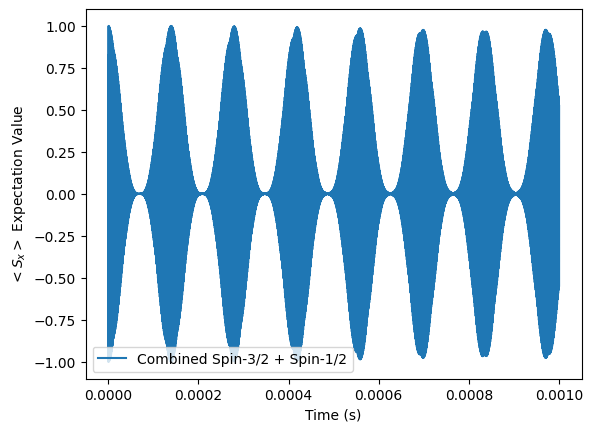

In [ ]:
# t-dependent H for combined system (spin-3/2 + spin-1/2)
def evolve_hamiltonian_combined(S_3_2, S_1_2, state_3_2, state_1_2, B, ge,gn, numtimesteps, Ahyp):
    time = linspace(0, 1e-3, numtimesteps)
    tstep = time[1] - time[0]

    H_3_2 = +gn * B * I_3_2.z  #Zeeman terms
    H_1_2 = +ge * B * S_1_2.z
    H_int = -Ahyp * (kron(I_3_2.x, S_1_2.x) + kron(I_3_2.y, S_1_2.y) + kron(I_3_2.z, S_1_2.z))  #H_int between two spins
    H_3_2exp = kron(H_3_2, identity(S_1_2.size))  # Expand to 8x8
    H_1_2exp = kron(identity(S_3_2.size), H_1_2)  # Expand to 8x8
    H_combined = H_3_2exp + H_1_2exp + H_int #Combined Hamiltonian, Zeeman and interaction
    print("\nCombined Hamiltonian:")
    df = pd.DataFrame(H_combined)
    display(df)

    U = asmatrix(expm(-1j *2*pi* H_combined * tstep))  # Time evo op U = exp(-i H dt)
    xProj = zeros(numtimesteps) #store <S_x> over time
    combined_state = kron(state_3_2, state_1_2) #tensor product of initial states

    # Iteration over time intervals
    for i in range(numtimesteps):
        combined_state = U @ combined_state
        #xProj[i] = (combined_state.H @ kron(I_3_2.x, identity(S_1_2.size)) @ combined_state).real.item()  #3/2 <I_x>
        xProj[i] += (combined_state.H @ kron(identity(I_3_2.size), S_1_2.x)*2 @ combined_state).real.item() #1/2 <S_x>

    return time, xProj

# Parameters for H evolution
ge = -28.0249514242e9  # Gyromagnetic ratio for electron (Hz/T)
gn = 13.981e6 #Gyromagnetic ratio for 87Rb spin-3/2 nuclei (Hz/T)
Ahyp = 6.834e9 #GHz
#B = 50e-6  # Bias field (in Tesla)
numtimesteps = 10001  # Number of time steps

# Evolve and calculate expectation values for the combined system
time_combined, xProj_combined = evolve_hamiltonian_combined(I_3_2, S_1_2, state_3_2, state_1_2, B, ge, gn, numtimesteps, Ahyp)  # Include interaction constant J

# Plot the results
import matplotlib.pyplot as plt
plt.figure()
plt.plot(time_combined, xProj_combined, label='Combined Spin-3/2 + Spin-1/2')
plt.xlabel('Time (s)')
plt.ylabel('$<S_x>$ Expectation Value')
#plt.xlim((0,1e-4))
plt.legend()
plt.savefig("beats.jpg")
plt.show()



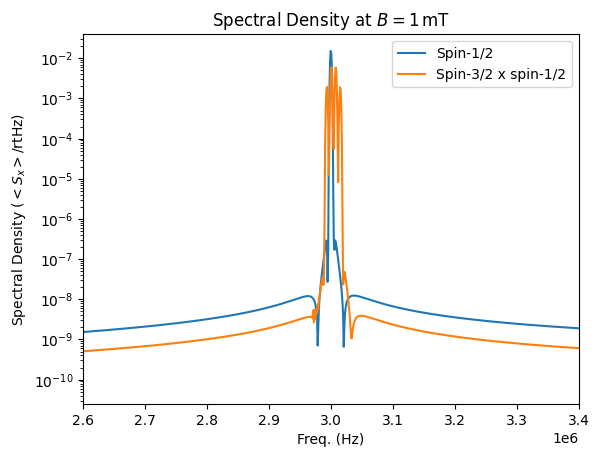

In [ ]:
freqs, FFTsig_87Rb =  powerSpectralDensity(xProj_combined,fs)
plt.semilogy(freqs, FFTsig, label='Spin-1/2')
plt.semilogy(freqs, FFTsig_87Rb, label='Spin-3/2 x spin-1/2')
plt.xlim(2.6e6,3.4e6)
plt.ylabel('Spectral Density ($<S_x>$/rtHz)')
plt.xlabel('Freq. (Hz)')
plt.title('Spectral Density at $B = 1\\,\\mathrm{mT}$')
plt.savefig("spectral1.jpg")
plt.legend()

"Nuclear slowing down Factor"

$g_{Rb} = g_e/(2I+1)$  

(28 GHz/T /(2*3/2+1)) = 28/4 = 7 GHz

Going to have to move to Density Matrix Formulation for proper handling of relaxation in all these states...

https://en.wikipedia.org/wiki/Density_matrix


But first, let's look at the Rabi problem in NMR for spin-1/2

$B = \hat{k}B_0 +\hat{i}B_1\cos(\omega t)$

The resonance frequency is going to be $\omega_0 = \gamma B_0$, if $B_0 >> B_1$

But, we really time-independent hamilitonians.

$i \hbar\frac{\partial \Psi}{\partial t} = H(t)\Psi$

Rotating frames!


# Attempt 1: Lab Frame to Rotational Frame

Good:

Max Difference of Sz between frames sufficiently small < e-16

Norms suggest transformation done correctly

Uniform circle of the Rotational frame expected

Concern: Comparison graph has Sz constant in lab frame, should be rotational. rotational frame has stagnation. Lab frame graph not visible.

# Attempt 2: Lab Frame to Rotational Frame

Make the entire thing iterative....

0.) make timebase... choose timestep ts = 1 ms. 1 us . whatever, tsteps = 1000. Need to have the timebase be small enough to track dynamics...

0a.) get timestep!



1.) for a given timestep, you can calculate rotation matrix for 'RF pulse on'

2.) for a given timestep, calculate rotation matrix for 'RF pulse off', free precession....

timestep is  0.001 ms


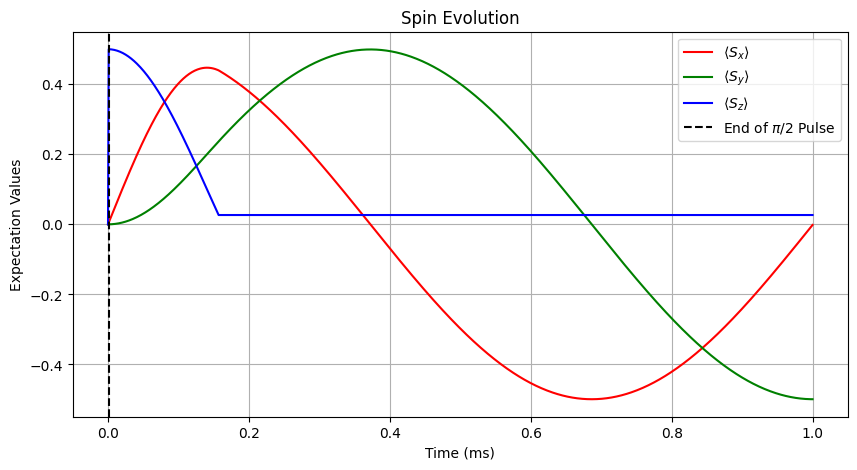

U_pulse matrix:
 [[ 0.99998438-2.49998698e-03j -0.00499997+0.00000000e+00j]
 [ 0.00499997-8.47032947e-22j  0.99998438+2.49998698e-03j]]
Expected π/2 pulse time: 0.15707963267948966 ms
γBz - ω_rf: 5


In [ ]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt

steps =1001
timebase = np.linspace(0,1,steps)
ts =  timebase[1]-timebase[0]
print('timestep is ', ts , 'ms')

# Pauli matrices
Sx = np.array([[0, 1], [1, 0]]) / 2
Sy = np.array([[0, -1j], [1j, 0]]) / 2
Sz = np.array([[1, 0], [0, -1]]) / 2

# Initial state (aligned with +z)
psi0 = np.array([[1], [0]])
gamma = 1
Bz = 105
B_rf = 10 #B_rf<<Bz
f = 100 #Variable rf frequency
w_rf = f

# RF pulse Hamiltonian
H_pulse = gamma*B_rf*Sy + (gamma*Bz - w_rf)*Sz #in rotating frame!

def calcEvolutionOp(H, tau):
    return expm(-1j * H * tau)

U_pulse = calcEvolutionOp(H_pulse, ts)  #evolution operator for pulses for a single timestep...

#??? evolution for free precession... in a rotating frame
H_free = (gamma * Bz - w_rf) * Sz
U_free = calcEvolutionOp(H_free, ts)

#declare a 'psi array' full of zeros..., then populate it through multiplying U_pulse over and over again....
psi = np.zeros((2, steps), dtype=complex)  # Stores states
psi[:, 0] = psi0[:, 0]  # initial state
#your pulse can be variable in duration, choose a pulse 0 - 50 ms, then view free precession for the rest...

Mx = np.zeros(steps)
My = np.zeros(steps)
Mz = np.zeros(steps)
t_pulse = np.pi / (2 * gamma * B_rf)

for i in range(1, steps):
    #Make time of RF pulse variable
    if i * ts < t_pulse:  # 50 ms pulse
        psi[:, i] = U_pulse @ psi[:, i - 1]
    # Free precession after RF pulse
    else:
        psi[:, i] = U_free @ psi[:, i - 1]

#printing results
    # Arrays for expectation values
    Mx[i] = np.real(psi[:, i].conj().T @ Sx @ psi[:, i])
    My[i] = np.real(psi[:, i].conj().T @ Sy @ psi[:, i])
    Mz[i] = np.real(psi[:, i].conj().T @ Sz @ psi[:, i])

# Plot the spin evolution
plt.figure(figsize=(10, 5))
plt.plot(timebase, Mx, label=r'$\langle S_x \rangle$', color='r')
plt.plot(timebase, My, label=r'$\langle S_y \rangle$', color='g')
plt.plot(timebase, Mz, label=r'$\langle S_z \rangle$', color='b')
plt.axvline(x=ts, color='k', linestyle='--', label="End of $\pi/2$ Pulse")

plt.xlabel("Time (ms)")
plt.ylabel("Expectation Values")
plt.title("Spin Evolution")
plt.legend()
plt.grid()
plt.show()

print("U_pulse matrix:\n", U_pulse)
print("Expected π/2 pulse time:", t_pulse, "ms")
print("γBz - ω_rf:", gamma * Bz - w_rf)

psi_after_pulse is [[0.70710678+0.j]
 [0.70710678+0.j]]


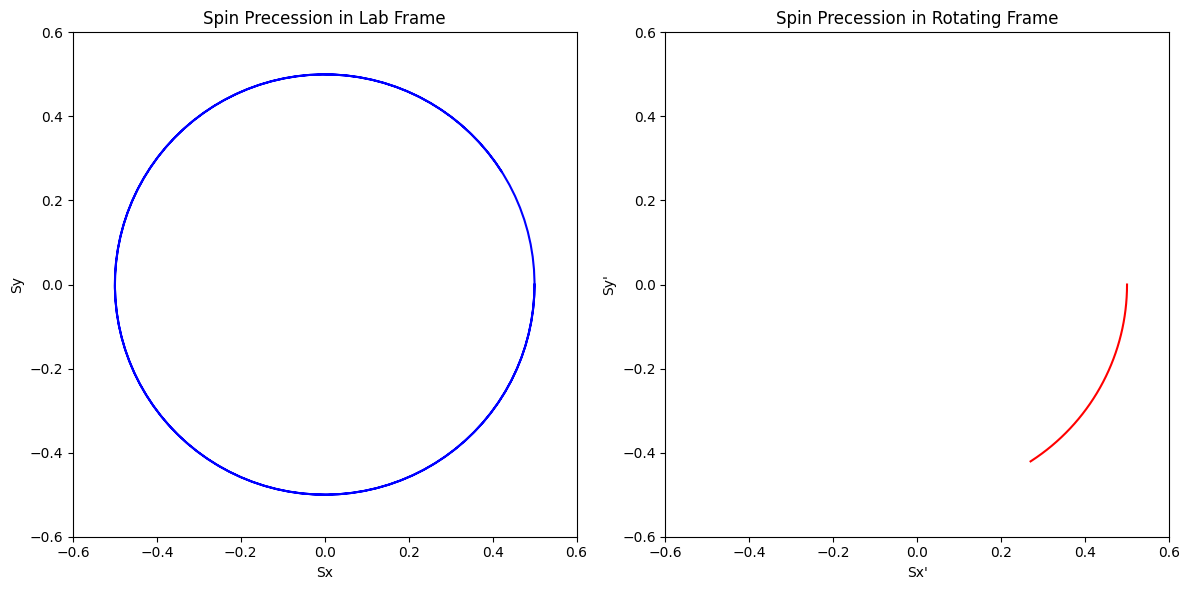

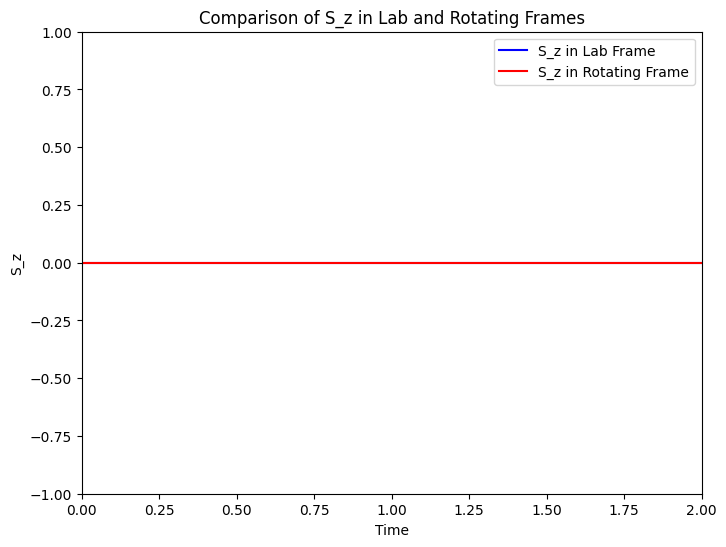

Maximum difference in S_z between frames: 1.0364972768961422e-16


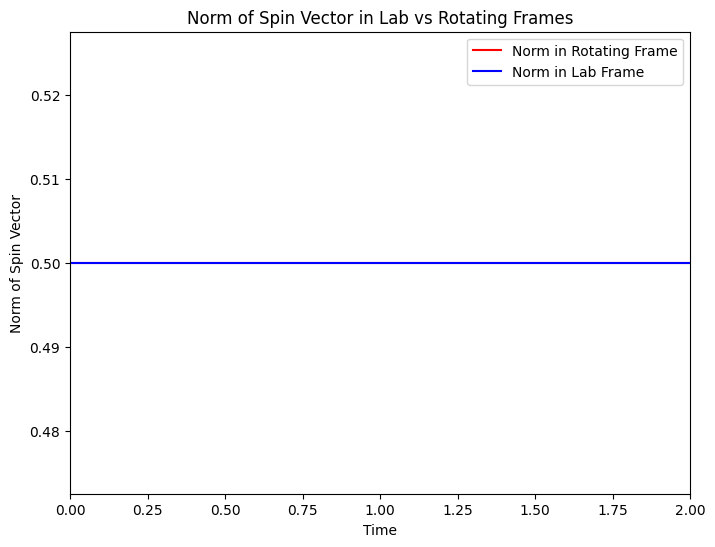

Maximum difference in norms: 2.220446049250313e-16


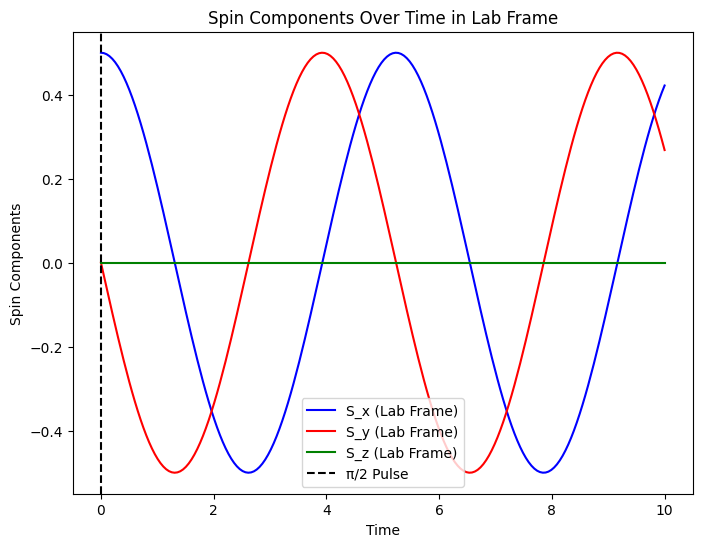

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm

# Constants
hbar = 1
gamma = 1
Bz = 1.0
B_rf = 0.1
delta = 0.1  # Detuning to avoid H_rot = 0
w_rf = gamma * (Bz + delta)

# Pauli matrices
Sx = np.array([[0, 1], [1, 0]]) / 2
Sy = np.array([[0, -1j], [1j, 0]]) / 2
Sz = np.array([[1, 0], [0, -1]]) / 2

# Initial state (aligned with +z)
psi0 = np.array([[1], [0]])

# RF pulse Hamiltonian
H_rf = gamma * B_rf * Sy

# Apply RF pulse
def apply_pulse(H, psi, duration):
    U = expm(-1j * H * duration / hbar)
    return U @ psi #/ np.linalg.norm(U @ psi)  # Normalize state

# Rotating frame transformation
def rotating_frame_transformation(psi, t):
    U_rot = expm(1j * w_rf * Sz * t)  # Correct unitary transformation
    psi_rot = expm(1j * w_rf * Sz * t) @ psi_lab
  # Transform the state
    return U_rot @ psi

# Effective Hamiltonian in rotating frame (fixed)
H_rot = -gamma * delta * Sz #- gamma * B_rf * Sx # Added transverse field term

# Evolve system and calculate expectation values
def evolve_system(H, psi, times, frame="rot"):
    spin_vectors = []
    for t in times:
        U = expm(-1j * H * t / hbar)
        psi_t = U @ psi
        psi_t /= np.linalg.norm(psi_t)  # Ensure normalization

        if frame == "lab":
            psi_t = expm(1j * w_rf * Sz * t) @ psi_t  # Transform to rotating frame

        # Compute expectation values correctly
        sx = np.real(np.vdot(psi_t, Sx @ psi_t))
        sy = np.real(np.vdot(psi_t, Sy @ psi_t))
        sz = np.real(np.vdot(psi_t, Sz @ psi_t))
        spin_vectors.append([sx, sy, sz])

    return np.array(spin_vectors)

# Simulation parameters
times = np.linspace(0, 10, 200)

# Apply π/2 pulse
psi_after_pulse = apply_pulse(H_rf, psi0, np.pi / (2 * gamma * B_rf))
print("psi_after_pulse is", psi_after_pulse)

# Simulate in lab and rotating frames
spin_vectors_lab = evolve_system(H_rot, psi_after_pulse, times, frame="lab")
spin_vectors_rot = evolve_system(H_rot, psi_after_pulse, times, frame="rot")

# Plot results with zooming
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Lab frame plot
ax1.plot(spin_vectors_lab[:, 0], spin_vectors_lab[:, 1], label="Spin Precession", color='b')
ax1.set_xlabel("Sx")
ax1.set_ylabel("Sy")
ax1.set_title("Spin Precession in Lab Frame")
ax1.set_xlim(-0.6, 0.6)
ax1.set_ylim(-0.6, 0.6)

# Rotating frame plot
ax2.plot(spin_vectors_rot[:, 0], spin_vectors_rot[:, 1], label="Spin Precession", color='r')
ax2.set_xlabel("Sx'")
ax2.set_ylabel("Sy'")
ax2.set_title("Spin Precession in Rotating Frame")
ax2.set_xlim(-0.6, 0.6)
ax2.set_ylim(-0.6, 0.6)

plt.tight_layout()
plt.show()

# Compare S_z component over time
plt.figure(figsize=(8, 6))
plt.plot(times, spin_vectors_lab[:, 2], label="S_z in Lab Frame", color='b')
plt.plot(times, spin_vectors_rot[:, 2], label="S_z in Rotating Frame", color='r')
plt.xlabel("Time")
plt.ylabel("S_z")
plt.title("Comparison of S_z in Lab and Rotating Frames")
plt.legend()
plt.xlim(0, 2)  # Zoom in on early times
plt.ylim(-1, 1)
plt.show()

# Check difference in S_z components
difference_sz = np.abs(spin_vectors_lab[:, 2] - spin_vectors_rot[:, 2])
max_diff_sz = np.max(difference_sz)
print(f"Maximum difference in S_z between frames: {max_diff_sz}")

# Check the norm of the spin vector
norm_lab = np.linalg.norm(spin_vectors_lab, axis=1)
norm_rot = np.linalg.norm(spin_vectors_rot, axis=1)

# Plot norm comparison
plt.figure(figsize=(8, 6))
plt.plot(times, norm_rot, label="Norm in Rotating Frame", color='red')
plt.plot(times, norm_lab, label="Norm in Lab Frame", color='blue')
plt.xlabel("Time")
plt.ylabel("Norm of Spin Vector")
plt.title("Norm of Spin Vector in Lab vs Rotating Frames")
plt.legend()
plt.xlim(0, 2)
plt.show()

# Check norm consistency
norm_diff = np.max(np.abs(norm_lab - norm_rot))
print(f"Maximum difference in norms: {norm_diff}")

# Define the time at which the π/2 pulse occurs
t_pulse = 0  # Assume pulse is applied at t=0

# Plot S_x, S_y, S_z over time
plt.figure(figsize=(8, 6))
plt.plot(times, spin_vectors_lab[:, 0], label="S_x (Lab Frame)", color='b')
plt.plot(times, spin_vectors_lab[:, 1], label="S_y (Lab Frame)", color='r')
plt.plot(times, spin_vectors_lab[:, 2], label="S_z (Lab Frame)", color='g')

# Add a vertical dashed line at the π/2 pulse moment
plt.axvline(t_pulse, color='k', linestyle='--', label="π/2 Pulse")

plt.xlabel("Time")
plt.ylabel("Spin Components")
plt.title("Spin Components Over Time in Lab Frame")
plt.legend()
plt.show()


Uniform ellipsoid in lab frame expected. Trailing in rotational frame not expected. Spin components vs. time graph shows that Sz is not constant, but oscillitory. Closer but not quite.

# Attempt 3/BEST: Lab Frame to Rotational Frame

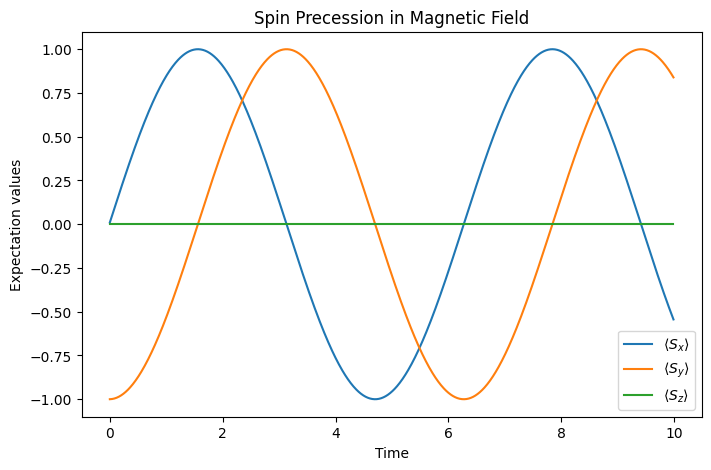

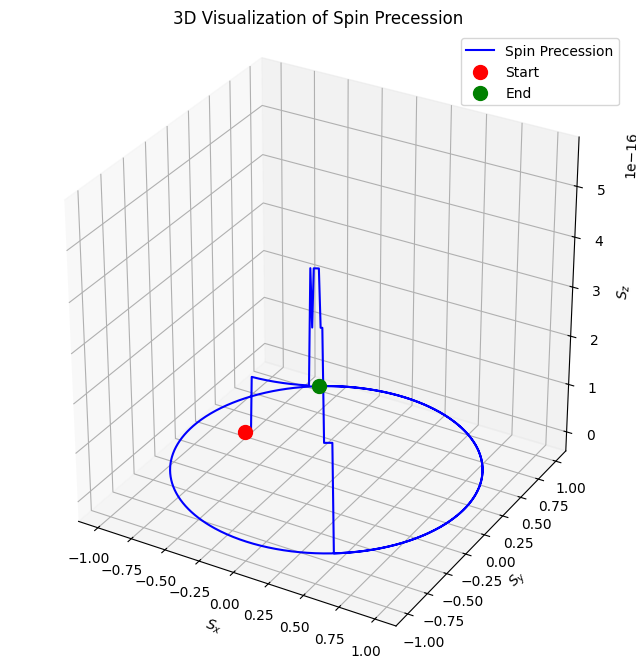

In [ ]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

# Pauli matrices
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)
I = np.eye(2, dtype=complex)

# Parameters
hbar = 1.0
gamma = 1.0
Bz = 1.0
B_rf = 0.1     # RF field along x
omega_L = gamma * Bz  # Larmor frequency
Omega_R = gamma * B_rf  # Rabi frequency
t_pulse = np.pi / (2 * Omega_R)  # π/2 pulse duration
t_max = 10  # Total evolution time
dt = 0.01  # Time step

# Time evolution operator in the lab frame
def evolution_operator(H, t):
    return la.expm(-1j * H * t)

# π/2 RF pulse operator (rotation about x)
U_pi2 = la.expm(-1j * (np.pi / 2) * sigma_x / 2)

# Initial density matrix: Start in |↑⟩ state
rho_0 = np.array([[1, 0], [0, 0]], dtype=complex)

# Apply π/2 pulse
rho = U_pi2 @ rho_0 @ U_pi2.conj().T  # Transforms |↑⟩ to |+⟩_x

# Define Hamiltonian in the lab frame (precession about z)
H_lab = (hbar * omega_L / 2) * sigma_z

# Rotating frame transformation
def rotating_frame_transform(t, omega_rot):
    return la.expm(1j * omega_rot * t * sigma_z / 2)

# Track expectation values
times = np.arange(0, t_max, dt)
Sx, Sy, Sz = [], [], []

# Time evolution
for t in times:
    # Transform to rotating frame
    R_rot = rotating_frame_transform(t, omega_L)
    rho_rot = R_rot @ rho @ R_rot.conj().T

    # Time evolution in rotating frame
    U_rot = evolution_operator(H_lab, dt)
    rho_rot = U_rot @ rho_rot @ U_rot.conj().T

    # Transform back to lab frame
    rho = R_rot.conj().T @ rho_rot @ R_rot

    # Compute expectation values
    Sx.append(np.trace(rho @ sigma_x).real)
    Sy.append(np.trace(rho @ sigma_y).real)
    Sz.append(np.trace(rho @ sigma_z).real)

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(times, Sx, label=r'$\langle S_x \rangle$')
plt.plot(times, Sy, label=r'$\langle S_y \rangle$')
plt.plot(times, Sz, label=r'$\langle S_z \rangle$')
plt.xlabel('Time')
plt.ylabel('Expectation values')
plt.legend()
plt.title('Spin Precession in Magnetic Field')
plt.show()

# 3D Plot of Spin Precession
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot trajectory
ax.plot(Sx, Sy, Sz, label="Spin Precession", color="b")

# Mark initial and final points
ax.scatter(Sx[0], Sy[0], Sz[0], color="r", label="Start", s=100)
ax.scatter(Sx[-1], Sy[-1], Sz[-1], color="g", label="End", s=100)

# Axis labels
ax.set_xlabel(r'$S_x$')
ax.set_ylabel(r'$S_y$')
ax.set_zlabel(r'$S_z$')
ax.set_title("3D Visualization of Spin Precession")

# Set aspect ratio
ax.set_box_aspect([1, 1, 1])  # Equal aspect ratio
ax.legend()
plt.show()

